In [1]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv1D, Conv1DTranspose, LeakyReLU, Dropout, Embedding, Concatenate
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.utils import pad_sequences, to_categorical

import pickle as pkl
from matplotlib import pyplot as plt

import re 
import pandas as pd 
import numpy as np 
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy.linalg import norm

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import line_tokenize
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [3]:
df = pd.read_csv('drive/MyDrive/ColabNotebooks/train_split_data_balance.csv')

In [4]:
df.head()

,id,tweet_url,img_url,labels,labels_value,tweet_text,labels_str
0,1107720189762785281,https://twitter.com/user/status/11077201897627...,http://pbs.twimg.com/tweet_video_thumb/D19pot-...,"[0, 0, 0]",0,Nigga been jammin have east like im from New Y...,"['NotHate', 'NotHate', 'NotHate']"
1,1064319619199102976,https://twitter.com/user/status/10643196191991...,http://pbs.twimg.com/media/DsU5C8sX4AEncr2.jpg,"[0, 5, 5]",5,Everyone say hello to my retarded son https://...,"['NotHate', 'OtherHate', 'OtherHate']"
2,1107125500126916608,https://twitter.com/user/status/11071255001269...,http://pbs.twimg.com/media/D11MxN6W0AAl1HU.jpg,"[1, 1, 1]",1,He killed his babymother then killed their dau...,"['Racist', 'Racist', 'Racist']"
3,1062682630846627840,https://twitter.com/user/status/10626826308466...,http://pbs.twimg.com/media/Dr9oOEqUcAEuLLU.jpg,"[5, 3, 3]",3,Faggot https://t.co/icwuxgx8Tq,"['OtherHate', 'Homophobe', 'Homophobe']"
4,1045031269204201473,https://twitter.com/user/status/10450312692042...,http://pbs.twimg.com/media/DoCyVOUXsAATbxh.jpg,"[0, 1, 1]",1,When the desert snake startles the female red...,"['NotHate', 'Racist', 'Racist']"


In [5]:
kaam_ka_df = df[['tweet_text', 'labels_value']]

In [6]:
# what we don't need

# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer

# cv = CountVectorizer()
# stemer = nltk.stem.PorterStemmer()
# tfidf = TfidfVectorizer()

In [7]:
kaam_ka_df.describe

<bound method NDFrame.describe of                                               tweet_text  labels_value
0      Nigga been jammin have east like im from New Y...             0
1      Everyone say hello to my retarded son https://...             5
2      He killed his babymother then killed their dau...             1
3                         Faggot https://t.co/icwuxgx8Tq             3
4      When the desert snake startles  the female red...             1
...                                                  ...           ...
32792  Someone take this cunt's phone. https://t.co/i...             2
32793  I smell crime ! Nigga's gon relate  🤣🦅 #machgo...             1
32794  lmao son this nigga is going to be bbq chicken...             1
32795  @moneymari97 Yeah nigga you done put the endin...             0
32796  All ISIS-held territory '100 per cent eliminat...             0

[32797 rows x 2 columns]>

In [9]:
x = kaam_ka_df['tweet_text']
y = kaam_ka_df['labels_value']

In [10]:
kaam_ka_df['labels_value']

0        0
1        5
2        1
3        3
4        1
        ..
32792    2
32793    1
32794    1
32795    0
32796    0
Name: labels_value, Length: 32797, dtype: int64

In [11]:
words = dict()

def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]] = np.array(line[1:], dtype=float)
      except:
        continue

add_to_dict(words, 'drive/MyDrive/ColabNotebooks/glove.6B.50d.txt')


In [12]:
pkl.dump(words, open('words.pkl', 'wb'))

In [13]:
listofwords =[]
for key in words:
  listofwords.append([key, words[key]])
len(listofwords)

400000

In [15]:
yy = np.array(y).reshape(-1,)
y = np.array(y)
y = to_categorical(y, num_classes = 6, dtype = 'int')

In [16]:
yy,y 

(array([0, 5, 1, ..., 1, 0, 0]),
 array([[1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0],
        ...,
        [0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0]]))

size of the data set is 2782


In [17]:
lemmatizer = WordNetLemmatizer()

def message_to_token_list(s):
  tokens = word_tokenize(s)
  lowercased_tokens = [t.lower() for t in tokens]
  lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
  for j in range(0, len(lemmatized_tokens)):
    if(lemmatized_tokens[j].__contains__('@') or lemmatized_tokens[j].__contains__('http')):
      lemmatized_tokens[j] = ''
  useful_tokens = [t for t in lemmatized_tokens if t in words]
  return useful_tokens

message_to_token_list(x[0])

['nigga',
 'been',
 'jammin',
 'have',
 'east',
 'like',
 'im',
 'from',
 'new',
 'york',
 ':']

In [18]:
vocabulary = []

def message_to_word_vectors(message, word_dict=words):
  vectors = []

  for token in message:
    if token not in word_dict:
      continue
    
    token_vector = word_dict[token]
    vocabulary.append([token, words[token]])
    vectors.append(token_vector)
  
  return np.array(vectors, dtype=float)

In [19]:
counter=0;
for curr in x:
  x[counter]=message_to_word_vectors(message_to_token_list(curr))
  counter=counter+1


<ipython-input-19-af4dcd5db64e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[counter]=message_to_word_vectors(message_to_token_list(curr))


In [20]:
len(vocabulary)

393718

In [21]:
x[0].shape

(11, 50)

In [22]:
xx = []

for i in x:
  xx.append(i)


In [23]:
xxx = pad_sequences(xx, maxlen = 25, padding = 'pre', value = 0.000, dtype = 'float')

In [24]:
xxx.shape

(32797, 25, 50)

In [25]:
y,yy

(array([[1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0],
        ...,
        [0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0]]),
 array([0, 5, 1, ..., 1, 0, 0]))

In [26]:
xxx.shape, y.shape, yy.shape

((32797, 25, 50), (32797, 6), (32797,))

In [27]:
vector_length = xxx.shape[1]

In [28]:
vector_length

25

In [29]:
xxx[0][22]

array([ 1.9511e-01,  5.0739e-01,  1.4709e-03,  4.1914e-02, -1.6759e-01,
        3.7517e-02, -1.3970e+00, -9.2398e-01, -2.4296e-01, -1.5171e-01,
       -4.7829e-01,  5.4612e-02, -2.4986e-01,  3.8398e-01,  1.6182e-02,
        3.4938e-01, -2.2627e-01,  8.6618e-02, -4.1001e-01, -1.8139e-01,
        7.5607e-01, -2.6200e-02, -6.9557e-01,  1.0874e-01, -4.7539e-01,
       -1.8095e+00, -1.6940e-01, -5.9863e-02, -1.6806e-01, -9.4546e-02,
        3.6610e+00,  4.1462e-02, -2.9161e-01, -6.9772e-01,  3.0805e-01,
       -2.8457e-01,  1.3217e-01, -7.6430e-03, -9.2390e-02, -4.9237e-01,
       -2.7055e-01,  6.0425e-02,  9.5107e-02, -2.3679e-01, -8.6108e-02,
        1.0243e+00, -2.2779e-01,  3.0488e-02, -1.4272e-01,  4.5411e-01])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        300         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 1250)      63750       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 25, 50)]     0           []                               
                                                                                              

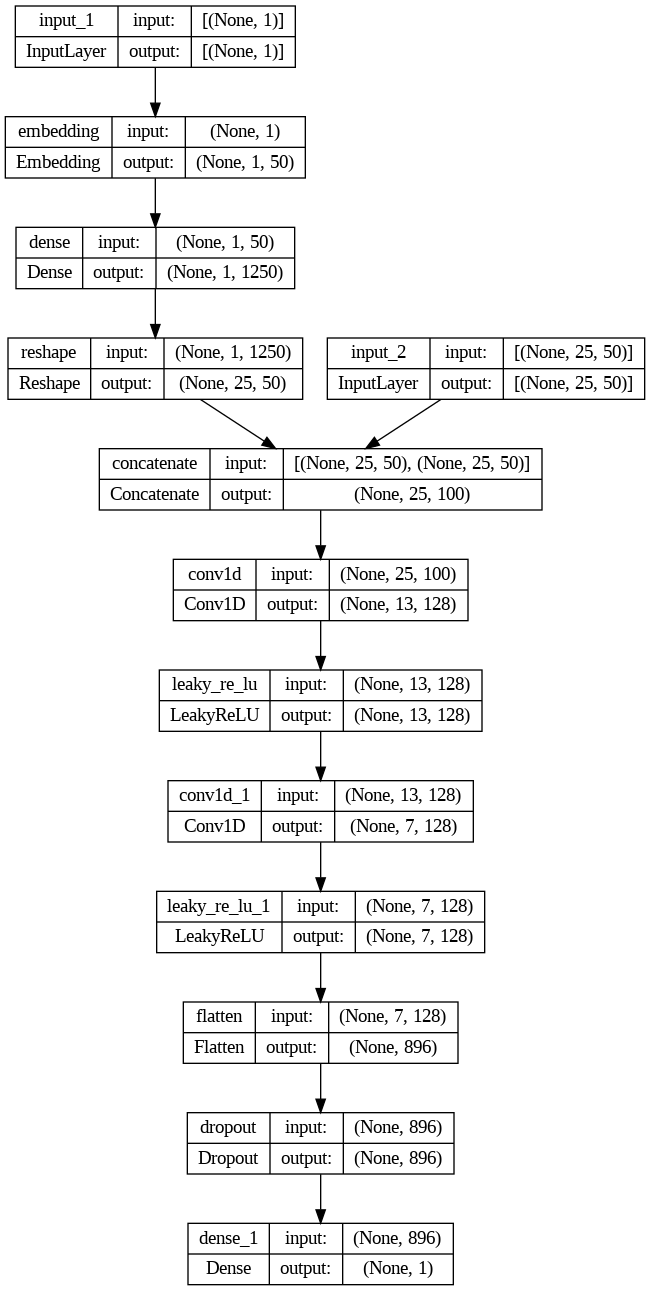

In [30]:
def define_discriminator(in_shape=(25,50), n_classes=6):
	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)
 
	n_nodes = in_shape[0] * in_shape[1] 
	li = Dense(n_nodes)(li)  
	li = Reshape((in_shape[0], 50))(li)  
 
	in_image = Input(shape=in_shape) 
 
	# in_image = Dense(n_nodes)(in_image)
	# in_image = Reshape((in_shape[0], 50))(in_image)

	merge = Concatenate()([in_image, li]) 
    
	fe = Conv1D(128, 3, strides=2, padding='same')(merge) 
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv1D(128, 3, strides=2, padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1
    
	model = Model([in_image, in_label], out_layer)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model




test_discr = define_discriminator()
print(test_discr.summary())
from tensorflow.keras.utils import plot_model
plot_model(test_discr, to_file='discr.png', show_shapes=True)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 1000)         101000      ['input_6[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        150         ['input_5[0][0]']                
                                                                                            

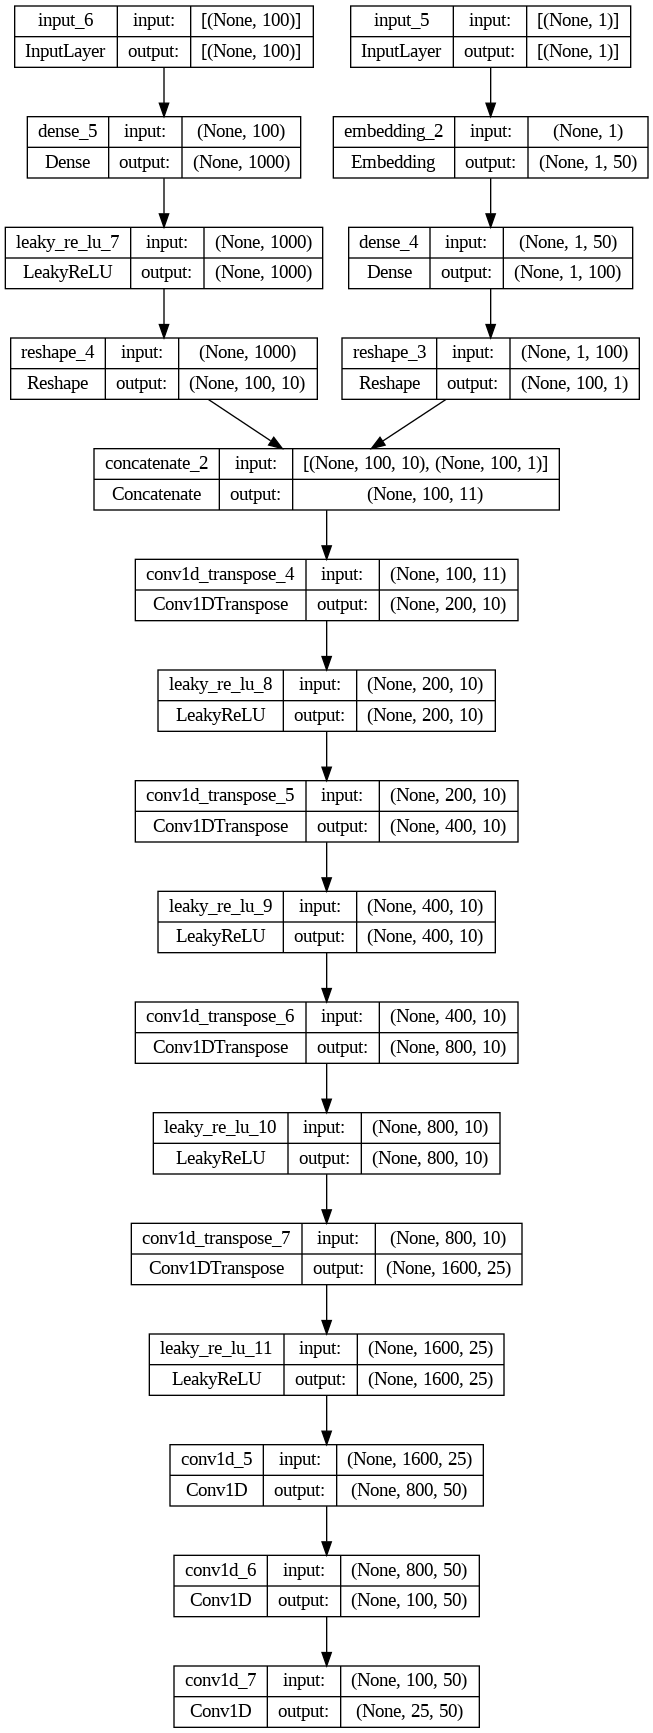

In [32]:
 def define_generator(latent_dim, n_classes=6):
	in_label = Input(shape=(1,))  
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
    
	# linear multiplication
	n_nodes = 100  # To match the dimensions for concatenation later in this step.  
	li = Dense(n_nodes)(li) 
	li = Reshape((100, 1))(li)
 


	# image generator input
	in_lat = Input(shape=(latent_dim,))  
	n_nodes = 1000
	gen = Dense(n_nodes)(in_lat)  
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((100, 10))(gen) 
 

	merge = Concatenate()([gen, li])  
 

	gen = Conv1DTranspose(10, 4, strides=2, padding='same')(merge) 
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv1DTranspose(10, 4, strides=2, padding='same')(gen) 
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv1DTranspose(10, 4, strides=2, padding='same')(gen) 
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv1DTranspose(25, 4, strides=2, padding='same')(gen) 
	gen = LeakyReLU(alpha=0.2)(gen)
 
	gen = Conv1D(50,4, strides = 2 , padding = 'same')(gen)
	gen = Conv1D(50,4, strides = 8 , padding = 'same')(gen)
	gen = Conv1D(50,4, strides = 4 , padding = 'same')(gen)
	
	out_layer = (gen) 

	model = Model([in_lat, in_label], out_layer)
	return model   

test_gen = define_generator(100, n_classes=3)
print(test_gen.summary())
plot_model(test_gen, to_file='gen.png', show_shapes=True)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 1000)         101000      ['input_6[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        150         ['input_5[0][0]']                
                                                                                            

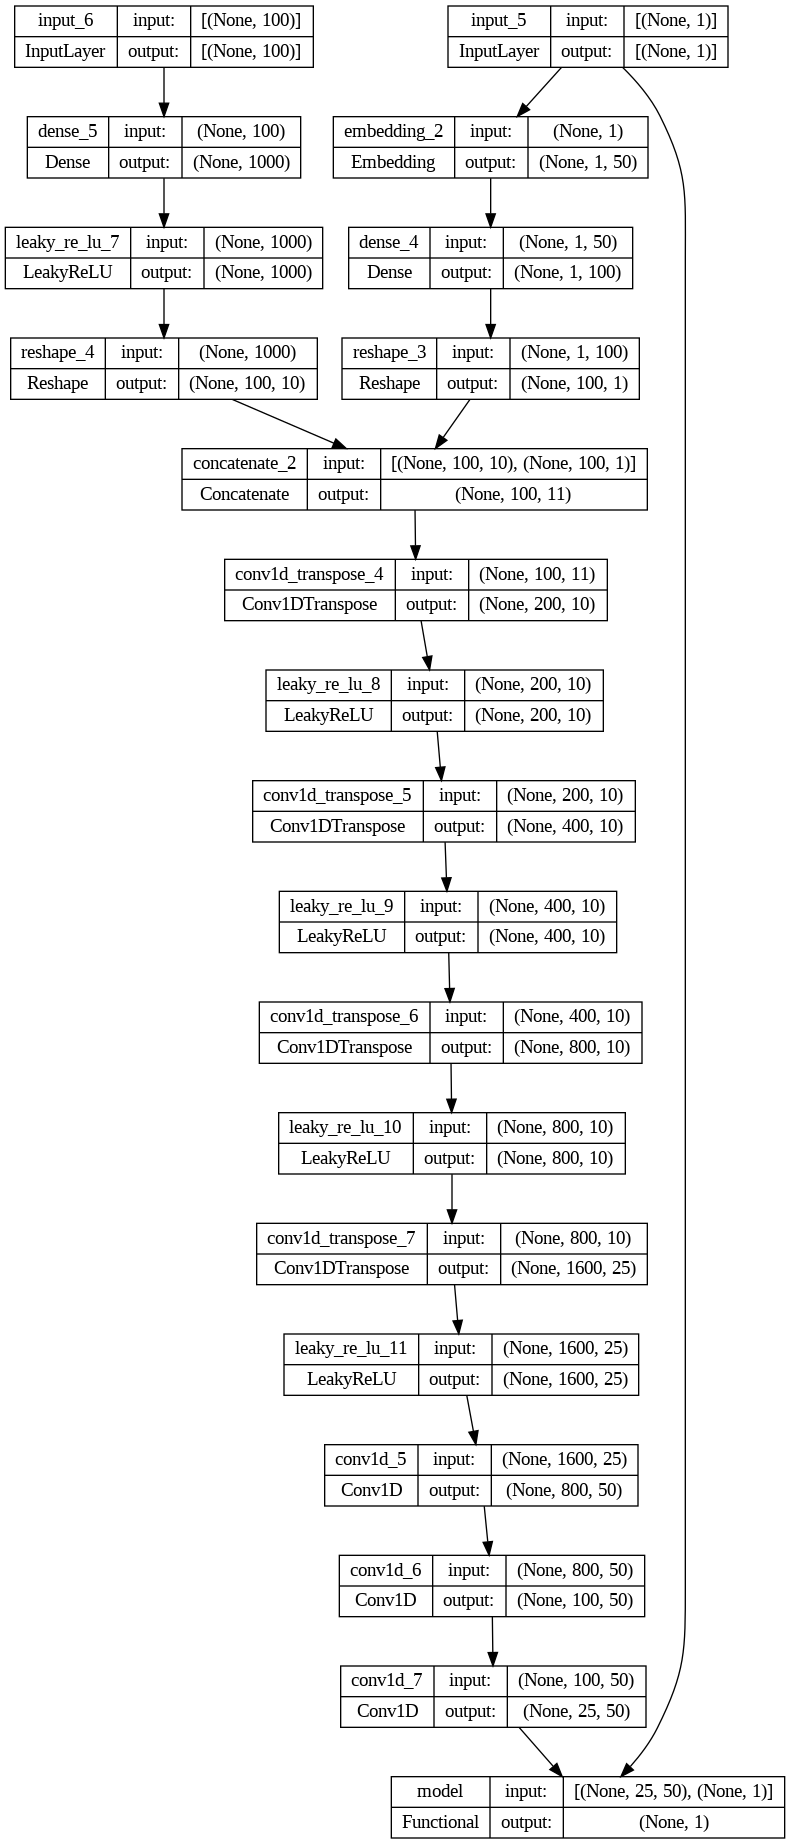

In [33]:
def define_gan(g_model, d_model):
	d_model.trainable = False  
	#Discriminator is trained separately. So set to not trainable.
	gen_noise, gen_label = g_model.input  
	gen_output = g_model.output  
	gan_output = d_model([gen_output, gen_label])
	model = Model([gen_noise, gen_label], gan_output)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

test_gan = define_gan(test_gen, test_discr)
test_gan.summary()
plot_model(test_gan, to_file='gAn.png', show_shapes=True)


In [34]:
def load_real_samples():
	return [xxx, yy]


In [35]:
def generate_real_samples(vectors, labels, n_samples):
	vectors, labels = vectors, labels  
	ix = randint(0, vectors.shape[0], n_samples)
	X, labels = vectors[ix], labels[ix]
	y = ones((n_samples, 1)) 
	return [X, labels], y

# check_generate_real_samples = generate_real_samples(x, y, 1)
# check_generate_real_samples

In [36]:
def generate_latent_points(latent_dim, n_samples, n_classes=3):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# check_generate_latent_points = generate_latent_points(100, 1, 3)
# check_generate_latent_points[0],check_generate_latent_points[1] 

In [37]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))  
	return [images, labels_input], y

# check_generate_fake_samples = generate_fake_samples(test_gen, 100, 1)
# check_generate_fake_samples

In [38]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=10):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
      	# Train the discriminator on real and fake images, separately (half batch each)
      	# Research showed that separate training is more effective. 
				# get randomly selected 'real' samples
      	# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(xxx, yy, half_batch)
            # update discriminator model weights
            # train_on_batch allows you to update weights based on a collection of samples you provide
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
				# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
				# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
        # d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
				# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
        # The generator wants the discriminator to label the generated samples as valid (ones)
        # This is where the generator is trying to trick discriminator into believing
        # the generated image is true (hence value of 1 for y)	
				# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
        # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        # job of folling the discriminator then the output would be 1 (true)
				# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
				# Print losses on this batch
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
		# save the generator model
	g_model.save('Generator.h5')
	d_model.save('Discriminator.h5')


In [39]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()

In [40]:
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128)

2/2 [==============================] - 0s 10ms/step
Epoch>1, Batch1/256, d1=0.650, d2=0.713 g=0.684
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch2/256, d1=0.414, d2=0.720 g=0.682
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch3/256, d1=0.296, d2=0.728 g=0.680
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch4/256, d1=0.174, d2=0.740 g=0.683
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch5/256, d1=0.125, d2=0.739 g=0.710
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch6/256, d1=0.085, d2=0.715 g=0.766
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch7/256, d1=0.101, d2=0.668 g=0.864
2/2 [==============================] - 0s 8ms/step
Epoch>1, Batch8/256, d1=0.108, d2=0.608 g=0.972
2/2 [==============================] - 0s 5ms/step
Epoch>1, Batch9/256, d1=0.098, d2=0.564 g=1.046
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch10/256, d1=0.090, d2=0.520 g=1.143
2/2 [===

KeyboardInterrupt: ignored

In [ ]:
countzero, countone, counttwo, countthree, countfour, countfive = 0,0,0,0,0
for i in range(0, len(yy)):
  if(yy[i]==0):
    countzero+=1
  elif(yy[i]==1):
    countone+=1
  elif(yy[i]==2):
    counttwo+=1
  elif(yy[i]==3):
    counttwo+=1
  elif(yy[i]==4):
    counttwo+=1
  elif(yy[i]==5):
    counttwo+=1
countzero, countone, counttwo, countthree, countfour, countfive

(365, 883, 1534)

no of ones to generate is 651 and number of zeroes to generate is 1169


In [ ]:
Generator = load_model('Generator.h5')

In [ ]:
def cosine_similarity(a,b):
  return np.dot(a,b)/(norm(a)*norm(b))

In [ ]:
#generate different value data 

def generatesamples(label, noofsample):
  latent_points, labels = generate_latent_points(100,noofsample)
  labels = np.arange(noofsample)
  for i in range(0, len(labels)):
    labels[i] = label
  labelVAL = Generator.predict([latent_points, labels])
  return labelVAL


In [ ]:
predzero = counttwo-countzero
predone = counttwo-countone

In [ ]:
generateZerolabel = generatesamples(0, predzero)
generateOnelabel = generatesamples(1, predone)

1/1 [==============================] - 0s 42ms/step


In [ ]:
def generateSentences(samplesVAL, vocabulary):
  sentences = []
  count = 0
  for j in generateZerolabel:
    count+=1
    words_zero = ''
    for i in j:
      maxi = 0
      word = ''
      for t in range(len(vocabulary)):
        cos_sim = cosine_similarity(np.array(vocabulary[t][1]), i)
        if(maxi< cos_sim):
          maxi = cos_sim
          word = vocabulary[t][0]
      if(maxi>0.5):
        words_zero+=word
        words_zero+=' '
    sentences.append(words_zero)
    print(count, words_zero)
  return sentences


In [ ]:
zero_sent = generateSentences(generateZerolabel, vocabulary)
one_sent = generateSentences(generateOnelabel, vocabulary)

1 time , with ) been double new well nah only chest ... true aww arrogant : swede sister one which one as http : 
2 hmn hand mama only fella one having stinky . his but but or which : : http : 
3 note first current gawd : only having gawd making being greasy being being aww and one with too one as http : 


KeyboardInterrupt: ignored

In [ ]:
pkl.dump(zero_sent, open('Zerosdataset.pkl', 'wb'))
pkl.dump(one_sent, open('Onesdataset.pkl', 'wb'))
